Anexo X

# Reentrenando modelo EfficientNet (modificado) que fue preentrenado en Kaggle

#### Elaborado por: Ricardo Niño de Rivera Barrón

#### Ingeniería Biónica

#### Trabajo Terminal II

En esta libreta reentrenamos el modeolo que se propone su despliegue en IBM Watson ya que fue modificado en algunos aspesctos que se detallan en el escrito final. Estos cambbios se realizaron porque IBM Watson no permite realizar modificaciones que no reconozca la versión de tensorflow que tiene activa en las versiones gratuitas para despliegue de modelos en su nube.

Este modelo se entrenó en Kaggle utilizando la tarjeta gráfica NVIDIA P100 para acelerar disminuir el tiempo de entrenamiento.

In [1]:
# Se instala una biblioteca con los modelos preentrenados EfficientNet
!pip install efficientnet

     |████████████████████████████████| 50 kB 543 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Llamamos a la biblioteca
import efficientnet.keras as efn

In [3]:
# Importando bibliotecas necesarias
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.image as mpimg
import sklearn
import tensorflow as tf

Ahora instalamos una nueva biblioteca para poder descargar archivos de MEGA.

In [4]:
# Instalanado mega.py
!pip install mega.py

     |████████████████████████████████| 49 kB 481 kB/s 
     |████████████████████████████████| 13.7 MB 938 kB/s 
  Created wheel for pathlib: filename=pathlib-1.0.1-py3-none-any.whl size=14346 sha256=25d6393d78806f9b5d3b616cd9df027d274d352a0a3d8b86d22c83504a1f06ca
  Stored in directory: /root/.cache/pip/wheels/6e/96/b8/10037fe231e23970bac58361d7c93571ab983a7bbc55e68550
Successfully built pathlib
  Attempting uninstall: tenacity
    Found existing installation: tenacity 6.1.0
    Uninstalling tenacity-6.1.0:
      Successfully uninstalled tenacity-6.1.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
# De la biblioteca mega importamos el método Mega
from mega import Mega

In [6]:
# Instanciando Mega en el objeto mega
mega = Mega()

Inicamos sesión en MEGA con cuenta temporal y anónima

In [7]:
# Log in en la cuenta de MEGA con cuenta temporal anónima
m = mega.login()

Descargando Base de Datos.

In [8]:
# Descargando Base de Datos
m.download_url('https://mega.nz/file/dBARgAIQ#uiQq4P-zC1fm6tV1I_udl2dtCiqzwyDadLyVlZ_dzAY')

PosixPath('BaseDeDatosFrontales_FINAL_256_bits.zip')

Como Kaggle es un entorno de desarrollo que trabaja en Linux utilizaremos algunos comandos nativos de este sistema operativo.

Para descomprimir el archivo utilizarmos el comando nativo de Linux <em>unzip</em>.



In [9]:
!unzip -q BaseDeDatosFrontales_FINAL_256_bits.zip

Descargamos los archivos necesarios.



In [10]:
# Descargando pos_train
m.download_url('https://mega.nz/file/Fcp12QzD#MLUFNaNeKJ8YFPo2bO1uNt7hnKCbDAy8S10s1-vKJ5Q')

PosixPath('pos_train.npy')

In [11]:
# Descargando pos_test
m.download_url('https://mega.nz/file/sQoFDaRB#Uh70-XjrqlGKaE9eBoc4puXnNxNFcQ0D23h_79rDnC4')

PosixPath('pos_test.npy')

In [12]:
# Descargando Y_train2.npy
m.download_url('https://mega.nz/file/tdohXarb#SRrt31GIT7H6gioCVm2KYF-sH6a8PHK8Z7Tr76oZb4I')

PosixPath('Y_train2.npy')

In [13]:
# Descargando Y_test2.npy
m.download_url('https://mega.nz/file/Vc5TBSbY#D8pbUvpA3l2V0PJxCu7Meg8WJ3wPpT6X2jEoDsleCWw')

PosixPath('Y_test2.npy')

Ahora se leen los archivos con numpy

In [14]:
pos_train = np.load('pos_train.npy')
pos_train.shape

(3337,)

In [15]:
pos_test = np.load('pos_test.npy')
pos_test.shape

(832,)

In [16]:
Y_train = np.load('Y_train2.npy')
Y_train.shape

(3337,)

In [17]:
# Agregando un dimensión para evitar errores con tensorflow
#Y_train = np.expand_dims(Y_train, axis=1)
#Y_train.shape

In [18]:
Y_test = np.load('Y_test2.npy')
Y_test.shape

(832,)

In [19]:
# Agregando un dimensión para evitar errores con tensorflow
#Y_test = np.expand_dims(Y_test, axis=1)
#Y_test.shape

Leemos los archivos en los directorios de interés.

In [20]:
# Leyendo archivos de entrenamiento
files=os.listdir("./BaseDeDatosFrontales_FINAL_256_bits/train")

In [21]:
# Leyendo archivos de validación
files2=os.listdir("./BaseDeDatosFrontales_FINAL_256_bits/test")

In [22]:
# Ordenando alfabeticamente el contenido de las listas
files.sort()
files2.sort()

### Construyendo X_train y X_test

Vamos a definir un nuevo tamaño de las imágenes para evitar problemas de memoria y acelerar el entrenamiento.

In [23]:
size_img = 128

In [24]:
# Definiendo función get_img para leer los archivos numpy y ajustarlos a nuevo tamaño.
# La imagen que retorna la función también es normalizada sobre los valor máximo del pixel (255)
def get_img(path, size, display_image = False):
  img = np.load(path)
  img = np.expand_dims(img, axis=2)
  if display_image == True:
    print(img.shape)
    plt.imshow(img[:,:,0], cmap='hot')

  return tf.image.resize(img, [size,size], antialias=True)/255

In [25]:
# Directorio raíz
path = "./BaseDeDatosFrontales_FINAL_256_bits/"

Realizamos una prueba de funcionamiento de la función

(480, 640, 1)


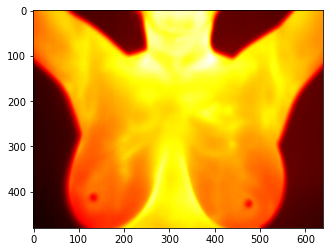

In [26]:
# Imagen original
hola=get_img(path+'train/'+files[1], size_img, display_image = True)

In [27]:
np.max(hola)

0.78683746

In [28]:
np.min(hola)

0.15518688

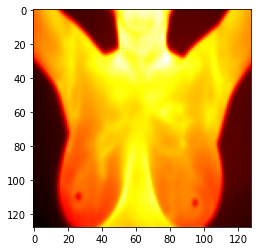

In [29]:
# Imagen resultante
plt.imshow(hola[:,:,0], cmap='hot')

Se leen los archivos y se ordenan en un nuevo arreglo.

In [30]:
# Entrenamiento X_train

# Creamos el arreglo para almacenar las imégenes
# Tendrá tres canales para  aprovechar los pesos preentrenados
# con imágenes de ImageNet
X_train = np.zeros((len(files), size_img, size_img,3))

for i in tqdm(range(len(files))):

  # Leemos y procesamos la imagen con respecto a pos_train
  temp_img = get_img(path+"train/"+files[pos_train[i]], size_img)

  # Almacenamos la imagen obtenida en cada canal
  X_train[i,:,:,0] = temp_img[:,:,0]
  X_train[i,:,:,1] = temp_img[:,:,0]
  X_train[i,:,:,2] = temp_img[:,:,0]

100%|██████████| 3337/3337 [00:15<00:00, 211.77it/s]


In [31]:
X_train.shape

(3337, 128, 128, 3)

In [32]:
# Validación X_test

# Creamos el arreglo para almacenar las imégenes
# Tendrá tres canales para  aprovechar los pesos preentrenados
# con imágenes de ImageNet
X_test = np.zeros((len(files2), size_img, size_img,3))

for i in tqdm(range(len(files2))):

  # Leemos y procesamos la imagen con respecto a pos_train
  temp_img = get_img(path+"test/"+files2[pos_test[i]], size_img)

  # Almacenamos la imagen obtenida en cada canal
  X_test[i,:,:,0] = temp_img[:,:,0]
  X_test[i,:,:,1] = temp_img[:,:,0]
  X_test[i,:,:,2] = temp_img[:,:,0]

100%|██████████| 832/832 [00:05<00:00, 146.78it/s]


In [33]:
X_test.shape

(832, 128, 128, 3)

In [34]:
# importando bibliotecas auxiliares
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
# Importando métricas de scikit learn}
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, accuracy_score

# Definiendo EfficientNet en https://github.com/qubvel/efficientnet/blob/master/efficientnet/model.py modificada para IBM Watson


In [36]:
from tensorflow import keras

In [37]:
from tensorflow.keras.models import load_model

In [38]:
tf.__version__

'2.3.1'

In [39]:
def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [40]:
def _preprocess_input(x, data_format=None, mode='caffe', **kwargs):
    """Preprocesses a tensor or Numpy array encoding a batch of images.
    # Arguments
        x: Input Numpy or symbolic tensor, 3D or 4D.
            The preprocessed data is written over the input data
            if the data types are compatible. To avoid this
            behaviour, `numpy.copy(x)` can be used.
        data_format: Data format of the image tensor/array.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
    # Returns
        Preprocessed tensor or Numpy array.
    # Raises
        ValueError: In case of unknown `data_format` argument.
    """
    backend, _, _, _ = get_submodules_from_kwargs(kwargs)

    if data_format is None:
        data_format = backend.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if isinstance(x, np.ndarray):
        return _preprocess_numpy_input(x, data_format=data_format,
                                       mode=mode, **kwargs)
    else:
        return _preprocess_symbolic_input(x, data_format=data_format,
                                          mode=mode, **kwargs)

In [41]:
IMAGENET_WEIGHTS_PATH = (
    'https://github.com/Callidior/keras-applications/'
    'releases/download/efficientnet/')

IMAGENET_WEIGHTS_HASHES = {
    'efficientnet-b0': ('163292582f1c6eaca8e7dc7b51b01c61'
                        '5b0dbc0039699b4dcd0b975cc21533dc',
                        'c1421ad80a9fc67c2cc4000f666aa507'
                        '89ce39eedb4e06d531b0c593890ccff3'),
    'efficientnet-b1': ('d0a71ddf51ef7a0ca425bab32b7fa7f1'
                        '6043ee598ecee73fc674d9560c8f09b0',
                        '75de265d03ac52fa74f2f510455ba64f'
                        '9c7c5fd96dc923cd4bfefa3d680c4b68'),
    'efficientnet-b2': ('bb5451507a6418a574534aa76a91b106'
                        'f6b605f3b5dde0b21055694319853086',
                        '433b60584fafba1ea3de07443b74cfd3'
                        '2ce004a012020b07ef69e22ba8669333'),
    'efficientnet-b3': ('03f1fba367f070bd2545f081cfa7f3e7'
                        '6f5e1aa3b6f4db700f00552901e75ab9',
                        'c5d42eb6cfae8567b418ad3845cfd63a'
                        'a48b87f1bd5df8658a49375a9f3135c7'),
    'efficientnet-b4': ('98852de93f74d9833c8640474b2c698d'
                        'b45ec60690c75b3bacb1845e907bf94f',
                        '7942c1407ff1feb34113995864970cd4'
                        'd9d91ea64877e8d9c38b6c1e0767c411'),
    'efficientnet-b5': ('30172f1d45f9b8a41352d4219bf930ee'
                        '3339025fd26ab314a817ba8918fefc7d',
                        '9d197bc2bfe29165c10a2af8c2ebc675'
                        '07f5d70456f09e584c71b822941b1952'),
    'efficientnet-b6': ('f5270466747753485a082092ac9939ca'
                        'a546eb3f09edca6d6fff842cad938720',
                        '1d0923bb038f2f8060faaf0a0449db4b'
                        '96549a881747b7c7678724ac79f427ed'),
    'efficientnet-b7': ('876a41319980638fa597acbbf956a82d'
                        '10819531ff2dcb1a52277f10c7aefa1a',
                        '60b56ff3a8daccc8d96edfd40b204c11'
                        '3e51748da657afd58034d54d3cec2bac')
}

NS_WEIGHTS_PATH = 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/'
NS_WEIGHTS_HASHES = {
    'efficientnet-b0': ('5e376ca93bc6ba60f5245d13d44e4323', 'a5b48ae7547fc990c7e4f3951230290d'),
    'efficientnet-b1': ('79d29151fdaec95ac78e1ca97fc09634', '4d35baa41ca36f175506a33918f7e334'),
    'efficientnet-b2': ('8c643222ffb73a2bfdbdf90f2cde01af', 'e496e531f41242598288ff3a4b4199f9'),
    'efficientnet-b3': ('3b29e32602dad75d1f575d9ded00f930', '47da5b154de1372b557a65795d3e6135'),
    'efficientnet-b4': ('c000bfa03bf3c93557851b4e1fe18f51', '47c10902a4949eec589ab92fe1c35ed8'),
    'efficientnet-b5': ('8a920cd4ee793f53c251a1ecd3a5cee6', '4d53ef3544d4114e2d8080d6d777a74c'),
    'efficientnet-b6': ('cc69df409516ab57e30e51016326853e', '71f96d7e15d9f891f3729b4f4e701f77'),
    'efficientnet-b7': ('1ac825752cbc26901c8952e030ae4dd9', 'e112b00c464fe929b821edbb35d1af55')
}

In [42]:
_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None

def get_submodules_from_kwargs(kwargs):
    #backend = kwargs.get('backend', _KERAS_BACKEND)
    backend=keras.backend
    #layers = kwargs.get('layers', _KERAS_LAYERS)
    layers = keras.layers
    #models = kwargs.get('models', _KERAS_MODELS)
    models = tf.keras.models
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils

In [43]:
# Copyright 2019 The TensorFlow Authors, Pavel Yakubovskiy, Björn Barz. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Contains definitions for EfficientNet model.
[1] Mingxing Tan, Quoc V. Le
  EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.
  ICML'19, https://arxiv.org/abs/1905.11946
"""

# Code of this model implementation is mostly written by
# Björn Barz ([@Callidior](https://github.com/Callidior))

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import math
import string
import collections

from six.moves import xrange
#from keras_applications.imagenet_utils import _obtain_input_shape
#from keras_applications.imagenet_utils import preprocess_input as _preprocess_input

#from . import get_submodules_from_kwargs
#from .weights import IMAGENET_WEIGHTS_PATH, IMAGENET_WEIGHTS_HASHES, NS_WEIGHTS_HASHES, NS_WEIGHTS_PATH

backend = None
layers = None
models = None
keras_utils = None

BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])
# defaults will be a public argument for namedtuple in Python 3.7
# https://docs.python.org/3/library/collections.html#collections.namedtuple
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}


def preprocess_input(x, **kwargs):
    kwargs = {k: v for k, v in kwargs.items() if k in ['backend', 'layers', 'models', 'utils']}
    return _preprocess_input(x, mode='torch', **kwargs)


def get_swish(**kwargs):
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    def swish(x):
        """Swish activation function: x * sigmoid(x).
        Reference: [Searching for Activation Functions](https://arxiv.org/abs/1710.05941)
        """

        if backend.backend() == 'tensorflow':
            try:
                # The native TF implementation has a more
                # memory-efficient gradient implementation
                return backend.tf.nn.swish(x)
            except AttributeError:
                pass

        return x * backend.sigmoid(x)

    return swish


def get_dropout(**kwargs):
    """Wrapper over custom dropout. Fix problem of ``None`` shape for tf.keras.
    It is not possible to define FixedDropout class as global object,
    because we do not have modules for inheritance at first time.
    Issue:
        https://github.com/tensorflow/tensorflow/issues/30946
    """
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    class FixedDropout(layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = backend.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    #return FixedDropout
    return Dropout


def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""

    return int(math.ceil(depth_coefficient * repeats))


def mb_conv_block(inputs, block_args, activation, drop_rate=None, prefix='', ):
    """Mobile Inverted Residual Bottleneck."""

    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    # workaround over non working dropout with None in noise_shape in tf.keras
    Dropout = get_dropout(
        backend=backend,
        layers=layers,
        models=models,
        utils=keras_utils
    )

    # Expansion phase
    filters = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = layers.Conv2D(filters, 1,
                          padding='same',
                          use_bias=False,
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'expand_conv')(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'expand_bn')(x)
        x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
    else:
        x = inputs

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(block_args.kernel_size,
                               strides=block_args.strides,
                               padding='same',
                               use_bias=False,
                               depthwise_initializer=CONV_KERNEL_INITIALIZER,
                               name=prefix + 'dwconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
    x = layers.Activation(activation, name=prefix + 'activation')(x)

    # Squeeze and Excitation phase
    if has_se:
        num_reduced_filters = max(1, int(
            block_args.input_filters * block_args.se_ratio
        ))
        se_tensor = layers.GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)

        target_shape = (1, 1, filters) if backend.image_data_format() == 'channels_last' else (filters, 1, 1)
        se_tensor = layers.Reshape(target_shape, name=prefix + 'se_reshape')(se_tensor)
        se_tensor = layers.Conv2D(num_reduced_filters, 1,
                                  activation=activation,
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer=CONV_KERNEL_INITIALIZER,
                                  name=prefix + 'se_reduce')(se_tensor)
        se_tensor = layers.Conv2D(filters, 1,
                                  activation='sigmoid',
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer=CONV_KERNEL_INITIALIZER,
                                  name=prefix + 'se_expand')(se_tensor)
        if backend.backend() == 'theano':
            # For the Theano backend, we have to explicitly make
            # the excitation weights broadcastable.
            pattern = ([True, True, True, False] if backend.image_data_format() == 'channels_last'
                       else [True, False, True, True])
            se_tensor = layers.Lambda(
                lambda x: backend.pattern_broadcast(x, pattern),
                name=prefix + 'se_broadcast')(se_tensor)
        x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')

    # Output phase
    x = layers.Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name=prefix + 'project_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=prefix + 'project_bn')(x)
    if block_args.id_skip and all(
            s == 1 for s in block_args.strides
    ) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = layers.add([x, inputs], name=prefix + 'add')

    return x


def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_resolution,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 depth_divisor=8,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet',
                 include_top=True,
                 weights='imagenet',
                 input_tensor=None,
                 input_shape=None,
                 pooling=None,
                 classes=1000,
                 **kwargs):
    """Instantiates the EfficientNet architecture using given scaling coefficients.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_resolution: int, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor: int.
        blocks_args: A list of BlockArgs to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False.
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', 'noisy-student', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_resolution,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if backend.backend() == 'tensorflow':
            from tensorflow.python.keras.backend import is_keras_tensor
        else:
            is_keras_tensor = backend.is_keras_tensor
        if not is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    #activation = get_swish(**kwargs)
    activation = "relu"

    # Build stem
    x = img_input
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2, 2),
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='stem_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    x = layers.Activation(activation, name='stem_activation')(x)

    # Build blocks
    num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
    block_num = 0
    for idx, block_args in enumerate(blocks_args):
        assert block_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters,
                                        width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters,
                                         width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

        # The first block needs to take care of stride and filter size increase.
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = mb_conv_block(x, block_args,
                          activation=activation,
                          drop_rate=drop_rate,
                          prefix='block{}a_'.format(idx + 1))
        block_num += 1
        if block_args.num_repeat > 1:
            # pylint: disable=protected-access
            block_args = block_args._replace(
                input_filters=block_args.output_filters, strides=[1, 1])
            # pylint: enable=protected-access
            for bidx in xrange(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                block_prefix = 'block{}{}_'.format(
                    idx + 1,
                    string.ascii_lowercase[bidx + 1]
                )
                x = mb_conv_block(x, block_args,
                                  activation=activation,
                                  drop_rate=drop_rate,
                                  prefix=block_prefix)
                block_num += 1

    # Build top
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation(activation, name='top_activation')(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        if dropout_rate and dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name='top_dropout')(x)
        x = layers.Dense(classes,
                         activation='softmax',
                         kernel_initializer=DENSE_KERNEL_INITIALIZER,
                         name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == 'imagenet':

        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment.h5'
            file_hash = IMAGENET_WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
            file_hash = IMAGENET_WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(
            file_name,
            IMAGENET_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
        )
        model.load_weights(weights_path)

    elif weights == 'noisy-student':

        if include_top:
            file_name = "{}_{}.h5".format(model_name, weights)
            file_hash = NS_WEIGHTS_HASHES[model_name][0]
        else:
            file_name = "{}_{}_notop.h5".format(model_name, weights)
            file_hash = NS_WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(
            file_name,
            NS_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
        )
        model.load_weights(weights_path)

    elif weights is not None:
        model.load_weights(weights)

    return model


def EfficientNetB0(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.0, 1.0, 224, 0.2,
        model_name='efficientnet-b0',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB1(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.0, 1.1, 240, 0.2,
        model_name='efficientnet-b1',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB2(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(
        1.1, 1.2, 260, 0.3,
        model_name='efficientnet-b2',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB3(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   **kwargs):
    return EfficientNet(
        1.2, 1.4, 300, 0.3,
        model_name='efficientnet-b3',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB4(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.4, 1.8, 380, 0.4,
        model_name='efficientnet-b4',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB5(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.6, 2.2, 456, 0.4,
        model_name='efficientnet-b5',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB6(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        1.8, 2.6, 528, 0.5,
        model_name='efficientnet-b6',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetB7(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        2.0, 3.1, 600, 0.5,
        model_name='efficientnet-b7',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )


def EfficientNetL2(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        **kwargs
):
    return EfficientNet(
        4.3, 5.3, 800, 0.5,
        model_name='efficientnet-l2',
        include_top=include_top, weights=weights,
        input_tensor=input_tensor, input_shape=input_shape,
        pooling=pooling, classes=classes,
        **kwargs
    )

setattr(EfficientNetB0, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB1, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB2, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB3, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB4, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB5, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB6, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetB7, '__doc__', EfficientNet.__doc__)
setattr(EfficientNetL2, '__doc__', EfficientNet.__doc__)

# Configurando EfficientNet modificada como en IBM Watson para obtener capa tipo modelo.


In [44]:
def inject_tfkeras_modules(func):
    import tensorflow.keras as tfkeras
    #@functools.wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['backend'] = tfkeras.backend
        kwargs['layers'] = tfkeras.layers
        kwargs['models'] = tfkeras.models
        kwargs['utils'] = tfkeras.utils
        return func(*args, **kwargs)

    return wrapper

In [45]:
EfficientNetB0 = inject_tfkeras_modules(EfficientNetB0)
EfficientNetB1 = inject_tfkeras_modules(EfficientNetB1)
EfficientNetB2 = inject_tfkeras_modules(EfficientNetB2)
EfficientNetB3 = inject_tfkeras_modules(EfficientNetB3)
EfficientNetB4 = inject_tfkeras_modules(EfficientNetB4)
EfficientNetB5 = inject_tfkeras_modules(EfficientNetB5)
EfficientNetB6 = inject_tfkeras_modules(EfficientNetB6)
EfficientNetB7 = inject_tfkeras_modules(EfficientNetB7)
EfficientNetL2 = inject_tfkeras_modules(EfficientNetL2)

# Arquitectura del modelo EfficientNet modificada que fue desplegada en IBM Watson.



In [46]:
# Arreglando el problema de clases desbalanceadas estableciendo un peso por clase en el función de costo
w_p=np.sum(Y_train==0)/Y_train.shape[0]
w_n=np.sum(Y_train==1)/Y_train.shape[0]

In [47]:
# Creando diccionario para establecer el peso de cada clase de salida
class_weights = { 0 : w_n , 1 : w_p }

In [48]:
# definimos dropout
# Esta factor que está definido entre 0 y 1
# es un factor que determina la tasa de unidades que se "apagarán"
# durante el entrenamiento; esto evita el sobreajuste
dropout = 0.2

In [49]:
# Dfiniendo modelo EfficentNet desplegado en IBM Watson
rnet_ibm = EfficientNetB7(weights='imagenet', include_top=False, input_shape=[128,128,3])
rnet_ibm = tf.keras.Sequential(rnet_ibm)
rnet_ibm.add(Dropout(rate=dropout))
rnet_ibm.add(Flatten())
rnet_ibm.add(Dense(4096, activation='relu'))
rnet_ibm.add(Dropout(rate=dropout))
rnet_ibm.add(Dense(4096, activation='relu'))
rnet_ibm.add(Dropout(rate=dropout))
rnet_ibm.add(Dense(1, activation='sigmoid'))

258441216/258434480 [==============================] - 8s 0us/step


In [50]:
rnet_ibm.layers

In [51]:
rnet_ibm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 4, 4, 2560)        64097680  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2560)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              167776256 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0

In [52]:
type(rnet_ibm)

tensorflow.python.keras.engine.sequential.Sequential

In [53]:
# Definimos el optimizador utilizando el método de Adam
# Este método es una modificación del algoritmo de
# gradiente descendiente
opt=tfa.optimizers.RectifiedAdam(learning_rate=0.01) #,clipvalue=5)
#opt=tf.keras.optimizers.Nadam(learning_rate=0.01 ,clipvalue=5)
#opt=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn) #,clipvalue=5)

In [54]:
# Definiendo las métricas necesarias para dar seguimiento al modelo
METRICS = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5),
  tf.keras.metrics.AUC(name='AUC')
]

In [55]:
# Compilando el modelo
rnet_ibm.compile(
    optimizer=opt,
    loss = 'binary_crossentropy',
    metrics=METRICS
)

La métrica de oro será el AUC.

In [56]:
# Con este objeto se guardará el mejor modelo con base a la métrica f1_score
sv = tf.keras.callbacks.ModelCheckpoint(filepath='EFNB7_IBM_weights.h5',monitor='val_AUC', verbose=0, save_best_only=True,
        save_weights_only=False, mode='max', save_freq='epoch')

In [57]:
# Tamaño del batch (se recomienda un batch potencia de 2)
BS = 32

In [58]:
# Entrenando el modelo y almacenando los valores en history_1
history_1 = rnet_ibm.fit(X_train, Y_train, batch_size=BS,
                          steps_per_epoch=len(X_train) // BS, validation_data=(X_test, Y_test),
                          epochs=40, verbose=2, class_weight=class_weights, callbacks=[sv])

Epoch 1/40
104/104 - 76s - loss: 0.3638 - accuracy: 0.7434 - precision: 0.3902 - recall: 0.7563 - f1_score: 0.5148 - AUC: 0.8044 - val_loss: 3.3084 - val_accuracy: 0.2776 - val_precision: 0.2776 - val_recall: 1.0000 - val_f1_score: 0.4346 - val_AUC: 0.6166
Epoch 2/40
104/104 - 59s - loss: 0.6332 - accuracy: 0.5265 - precision: 0.2491 - recall: 0.7983 - f1_score: 0.3797 - AUC: 0.6973 - val_loss: 6304466.5000 - val_accuracy: 0.7224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_AUC: 0.5000
Epoch 3/40
104/104 - 70s - loss: 0.1655 - accuracy: 0.7014 - precision: 0.3509 - recall: 0.7915 - f1_score: 0.4862 - AUC: 0.8185 - val_loss: 0.5941 - val_accuracy: 0.7909 - val_precision: 0.6418 - val_recall: 0.5584 - val_f1_score: 0.5972 - val_AUC: 0.8578
Epoch 4/40
104/104 - 59s - loss: 0.1059 - accuracy: 0.8587 - precision: 0.5770 - recall: 0.8545 - f1_score: 0.6889 - AUC: 0.9293 - val_loss: 0.5347 - val_accuracy: 0.7332 - val_precision: 0.5120 - val_recall: 0.

In [59]:
# Primera iteración con el AUC de validación más alto
best_iter=np.where(np.max(history_1.history['val_AUC'])==history_1.history['val_AUC'])[0][0]
print(best_iter)

2


In [60]:
# AUC más alto
history_1.history['val_AUC'][best_iter]

0.8578127026557922

In [61]:
# Definiendo la función para desplegar la curva ROC
def plot_roc(name, labels, predictions, name_fig):
    fp, tp, _ = roc_curve(labels, predictions)
    auc1 = auc(fp, tp)
    lw=2

    plt.plot(100*fp, 100*tp, linewidth=2, lw=lw, color='darkorange', label='ROC curve (area = %0.2f)' % auc1)
    plt.plot([0, 100], [0, 100], color='navy', lw=lw, linestyle='--',label='Random')
    plt.xlabel('Falsos positivos [%]')
    plt.ylabel('Verdaderos positivos [%]')
    plt.xlim([-5,105])
    plt.ylim([-5,105])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.savefig('ROC_'+name_fig+'.png')

In [62]:
# Definiendo función para visualizar curvas de entrenamiento
def display_training_curves(training, validation, title, subplot):   ####2
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('Iteración')
    ax.legend(['Entrenamiento', 'Validación.'])
    ax.scatter(best_iter, validation[best_iter], c='#ff7f0e', s=500)
    bbox = dict(boxstyle="round", fc="0.9")
    ax.annotate("Iteración con AUC más alto", (best_iter, validation[best_iter]), bbox=bbox)
    plt.savefig(str(title)+'.png')

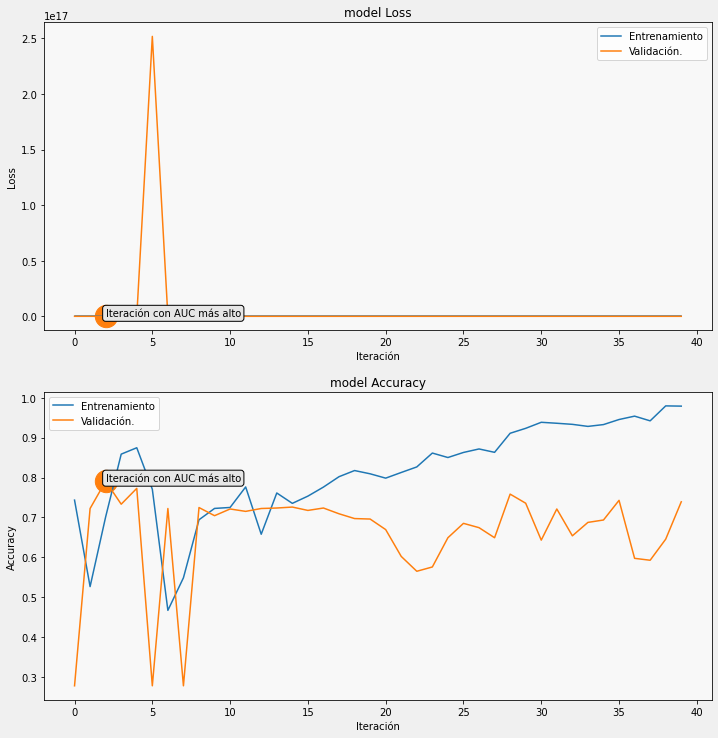

In [63]:
# Desplegando curvas (loss & accuracy)
display_training_curves(history_1.history['loss'], history_1.history['val_loss'], 'Loss', 211)
display_training_curves(history_1.history['accuracy'], history_1.history['val_accuracy'], 'Accuracy', 212)

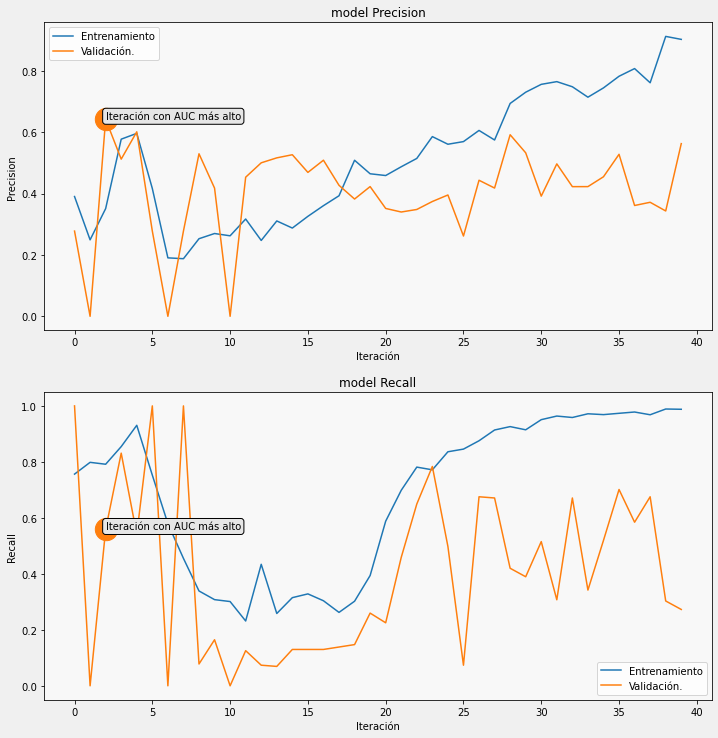

In [64]:
# Desplegando curvas (precision & recall)
display_training_curves(history_1.history['precision'], history_1.history['val_precision'], 'Precision', 211)
display_training_curves(history_1.history['recall'], history_1.history['val_recall'], 'Recall', 212)

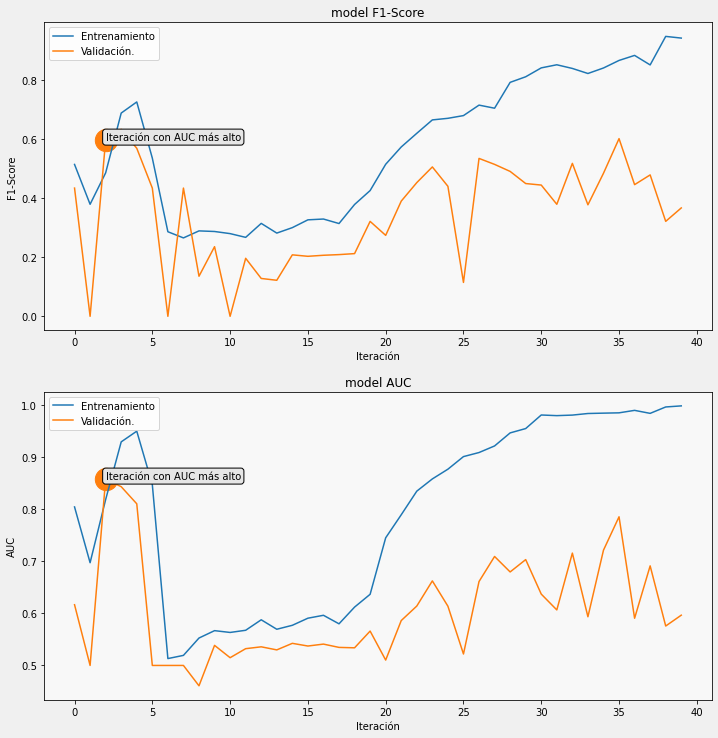

In [65]:
# Desplegando curvas (f1_score & AUC)
display_training_curves(history_1.history['f1_score'], history_1.history['val_f1_score'], 'F1-Score', 211)
display_training_curves(history_1.history['AUC'], history_1.history['val_AUC'], 'AUC', 212)

In [66]:
# Cargamos el modelo con la mejor métrica de AUC en validación
rnet_ibm.load_weights("EFNB7_IBM_weights.h5")

# Métricas y gráficas de validación.

In [67]:
# Calculando las predicciones para Red Neuronal
Y_train_pred = (rnet_ibm.predict(X_train) > 0.5).astype("int32")
Y_train_proba = rnet_ibm.predict(X_train) # Arreglo de probabilidades
Y_test_pred = (rnet_ibm.predict(X_test) > 0.5).astype("int32")
Y_test_proba = rnet_ibm.predict(X_test) # Arreglo de probabilidades

Lamentablemente Tensorflow subestima la métrica F1-Score y Sobrestima la métrica AUC. Para este trabajo se reportarán los resultados con base en la biblioteca de Scikit-Learn y se utilizará las métricas de TensorFlow sólo como auxiliar para hallar el valor más alto ponderado durante las iteracion o entrenamiento.

Por tanto es posible que algunas gráficas del entrenamiento difieran con los resultados finales de estas dos métricas.

A continuación de realiza una demostración de lo anteriromente descrito.




In [68]:
# Desplegando métrica del rendimiento
print("EfficientNet IBM Watson (modificada) TensorFlow Metrics")
print()
print("MÉTRICAS EN ENTRENAMIENTO")
metric = tf.keras.metrics.BinaryAccuracy()
metric.update_state(Y_train, Y_train_pred)
print("Accuracy: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Precision()
metric.update_state(Y_train, Y_train_pred)
print("Precision: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Recall()
metric.update_state(Y_train, Y_train_pred)
print("Recall: %0.2f%%"%(100*metric.result().numpy()))
metric = tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5)
metric.update_state(Y_train, Y_train_pred)
print("F1-Score: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.AUC()
metric.update_state(Y_train, Y_train_proba)
print("AUC: %0.2f%%"%(100*metric.result().numpy()))
print()
print("MÉTRICAS EN VALIDACIÓN")
metric = tf.keras.metrics.BinaryAccuracy()
metric.update_state(Y_test, Y_test_pred)
print("Accuracy: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Precision()
metric.update_state(Y_test, Y_test_pred)
print("Precision: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Recall()
metric.update_state(Y_test, Y_test_pred)
print("Recall: %0.2f%%"%(100*metric.result().numpy()))
metric = tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5)
metric.update_state(Y_test, Y_test_pred)
print("F1-Score: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.AUC()
metric.update_state(Y_test, Y_test_proba)
print("AUC: %0.2f%%"%(100*metric.result().numpy()))
print()
print()
print("EfficientNet IBM Watson (modificada) SciKit-Learn Metrics")
print()
print("MÉTRICAS EN ENTRENAMIENTO")
print("Accuracy: %0.2f%%"%(100*accuracy_score(Y_train, Y_train_pred)))
print("Precision: %0.2f%%"%(100*precision_score(Y_train, Y_train_pred)))
print("Recall: %0.2f%%"%(100*recall_score(Y_train, Y_train_pred)))
print("F1-Score: %0.2f%%"%(100*f1_score(Y_train, Y_train_pred)))
fp, tp, _ = roc_curve(Y_train, Y_train_proba)
print("AUC: %0.2f%%"%(100*auc(fp, tp)))
print()
print("MÉTRICAS EN VALIDACIÓN")
print("Accuracy: %0.2f%%"%(100*accuracy_score(Y_test, Y_test_pred)))
print("Precision: %0.2f%%"%(100*precision_score(Y_test, Y_test_pred)))
print("Recall: %0.2f%%"%(100*recall_score(Y_test, Y_test_pred)))
print("F1-Score: %0.2f%%"%(100*f1_score(Y_test, Y_test_pred)))
fp, tp, _ = roc_curve(Y_test, Y_test_proba)
print("AUC: %0.2f%%"%(100*auc(fp, tp)))
print()

EfficientNet IBM Watson (modificada) TensorFlow Metrics

MÉTRICAS EN ENTRENAMIENTO
Accuracy: 87.95%
Precision: 65.87%
Recall: 68.94%
F1-Score: 18.45%
AUC: 92.11%

MÉTRICAS EN VALIDACIÓN
Accuracy: 79.09%
Precision: 64.18%
Recall: 55.84%
F1-Score: 25.84%
AUC: 85.78%


EfficientNet IBM Watson (modificada) SciKit-Learn Metrics

MÉTRICAS EN ENTRENAMIENTO
Accuracy: 87.95%
Precision: 65.87%
Recall: 68.94%
F1-Score: 67.37%
AUC: 92.33%

MÉTRICAS EN VALIDACIÓN
Accuracy: 79.09%
Precision: 64.18%
Recall: 55.84%
F1-Score: 59.72%
AUC: 86.21%



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  import sys


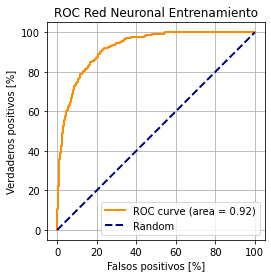

In [69]:
# Curva ROC de entrenamiento
plot_roc('ROC Red Neuronal Entrenamiento', Y_train, Y_train_proba, name_fig='EFNB7 IBM Watson (modificada)')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  import sys


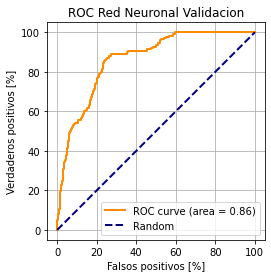

In [70]:
# Curva de Roc de Validación
plot_roc('ROC Red Neuronal Validacion', Y_test, Y_test_proba, name_fig='EFNB7 IBM Watson (modificada)')

Conforme a los resultados anteriores se tomará la decisión de despliegue del modelo en el servicio de IBM Watson en función del rendimiento del rendimiento del modelo.

Eliminando archivos innecesarios para guardar la libreta en Kaggle

In [71]:
import shutil

dir_path = './BaseDeDatosFrontales_FINAL_256_bits'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

In [72]:
os.remove("./BaseDeDatosFrontales_FINAL_256_bits.zip")